# Training the rough Bergomi model part 5

In this notebook we train a neural network for the rough Bergomi model for expiries in the range (0.40,1.00].

Be aware that the datasets are rather large.



In [1]:
MODEL_PART = str(5)

import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
keras.backend.backend()

'plaidml'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os, sys, pandas as pd, numpy as np
wd = os.getcwd()

path_seperator = os.path.sep

sys.path.append(wd + path_seperator + 'optimizers')
from AdamW import AdamW
from QHAdam import QHAdam

### Load, split and scale the datasets

In [3]:
optimizers=[keras.optimizers.Adam(), AdamW(), QHAdam()]

# Load contract grid:
logMoneyness = pd.read_csv(wd + path_seperator + 'data' + path_seperator + 'logMoneyness.txt', delimiter=",", header = None).values
expiries = pd.read_csv(wd + path_seperator + 'data' + path_seperator + 'expiries.txt', delimiter=",", header = None).values

# Set useful parameters:
nIn = 25
nOut = 175
nXi = 22

# Load training data:
data_train = pd.read_csv(wd + path_seperator + 'data' + path_seperator + 'training_and_test_data' + path_seperator + 'rbergomi_training_data_' + MODEL_PART + '.csv', delimiter=",").values
x_train = data_train[:,:nIn]
y_train = data_train[:,nIn:nIn+nOut]
data_train = None

# Load test data:
data_test = pd.read_csv(wd + path_seperator + 'data' + path_seperator + 'training_and_test_data' + path_seperator + 'rbergomi_test_data_' + MODEL_PART + '.csv', delimiter=",").values
x_valid = data_test[:,:nIn]
y_valid = data_test[:,nIn:nIn+nOut]
data_test = None

# Normalise data:
from sklearn.preprocessing import StandardScaler

tmp1 = np.reshape(np.array([0.50,3.50,0.00]), (1, 3))
tmp2 = np.reshape(np.array([0.00,0.75,-1.00]), (1, 3))
ub = np.concatenate((tmp1,np.tile(1,(1,nXi))),1)
lb = np.concatenate((tmp2,np.tile(0.0025,(1,nXi))),1)

def myscale(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=(x[i] - (ub[0,i] + lb[0,i])*0.5) * 2 / (ub[0,i] - lb[0,i])
        
    return res

def myinverse(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=x[i]*(ub[0,i] - lb[0,i]) *0.5 + (ub[0,i] + lb[0,i])*0.5
        
    return res

# Scale inputs:
x_train_mod = np.array([myscale(x) for x in x_train])
x_valid_mod = np.array([myscale(x) for x in x_valid])

# Scale and normalise output:
scale_y =  StandardScaler()
y_train_mod = scale_y.fit_transform(y_train)
y_valid_mod = scale_y.transform(y_valid)

INFO:plaidml:Opening device "metal_amd_radeon_pro_450.0"


### Define utility functions

In [4]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
#keras.backend.set_floatx('float64')

def GetNetwork(nIn,nOut,nNodes,nLayers,actFun):
    # Description: Creates a neural network of a specified structure
    input1 = keras.layers.Input(shape=(nIn,))
    layerTmp = keras.layers.Dense(nNodes,activation = actFun)(input1) 
    for i in range(nLayers-1):
        layerTmp = keras.layers.Dense(nNodes,activation = actFun)(layerTmp) 
    output1 = keras.layers.Dense(nOut,activation = 'linear')(layerTmp)
    return(keras.models.Model(inputs=input1, outputs=output1))

def TrainNetwork(nn,batchsize,numEpochs,objFun,optimizer,xTrain,yTrain,xTest,yTest):
    # Description: Trains a neural network and returns the network including the history
    # of the training process.
    nn.compile(loss = objFun, optimizer = optimizer)
    model.summary()
    history = nn.fit(xTrain, 
                     yTrain, 
                     batch_size = batchsize,
                     validation_data = (xTest,yTest),
                     epochs = numEpochs, 
                     verbose = True, 
                     shuffle=1) 
    return nn,history.history['loss'],history.history['val_loss']

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square( y_pred - y_true )))

### Define and train neural network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>

In [ ]:
# Set seed
import random
random.seed(455165)

models = {}

for opti in optimizers:
    # Define model:
    model = GetNetwork(nIn,nOut,200,3,'elu')

    # Train network
    model,loss1,vloss1 = TrainNetwork(model,64,500,root_mean_squared_error,   opti,   x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)
    model,loss2,vloss2 = TrainNetwork(model,5000,200,root_mean_squared_error,   opti,   x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)
    models[opti.__class__.__name__] = [model, loss1, vloss1, loss2, vloss2]

### Save losses of trainings
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>

In [ ]:
import pandas as pd
for key, value in models.items():
    dl = {'loss1_' + key: value[1], 'vloss1_' + key: value[2]}
    dvl = {'loss2_' + key: value[3], 'vloss2_' + key: value[4]}
    df = pd.DataFrame(data=dl)

    df.to_csv(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'training_loss' + path_seperator + 'rbergomi_model_' + MODEL_PART + '_' + key + '_' + 'loss1' + '.csv', encoding='utf-8', index=False)
    df = pd.DataFrame(data=dvl)

    df.to_csv(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'training_loss' + path_seperator + 'rbergomi_model_' + MODEL_PART + '_' + key + '_' + 'loss2' + '.csv', encoding='utf-8', index=False)

### Save network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>


In [ ]:
for key, value in models.items():
    # Save model:
    value[0].save(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'rbergomi_model_' + MODEL_PART + '_' + key + '.h5')

    # Save weights (and scalings) in JSON format:
    # - You need to install 'json-tricks' first.
    # - We need this file for proper import into Matlab, R... etc.
    weights_and_more = value[0].get_weights()
    weights_and_more.append(0.5*(ub + lb))
    weights_and_more.append(np.power(0.5*(ub - lb),2))
    weights_and_more.append(scale_y.mean_)
    weights_and_more.append(scale_y.var_)

    import codecs, json 
    for idx, val in enumerate(weights_and_more):
        weights_and_more[idx] = weights_and_more[idx].tolist()

    json_str = json.dumps(weights_and_more)

    text_file = open(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'rbergomi_weights_' + MODEL_PART + '_' + key + ".json", "w")
    text_file.write(json_str)
    text_file.close()

### Validate approximation

Model Parameters Adam (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


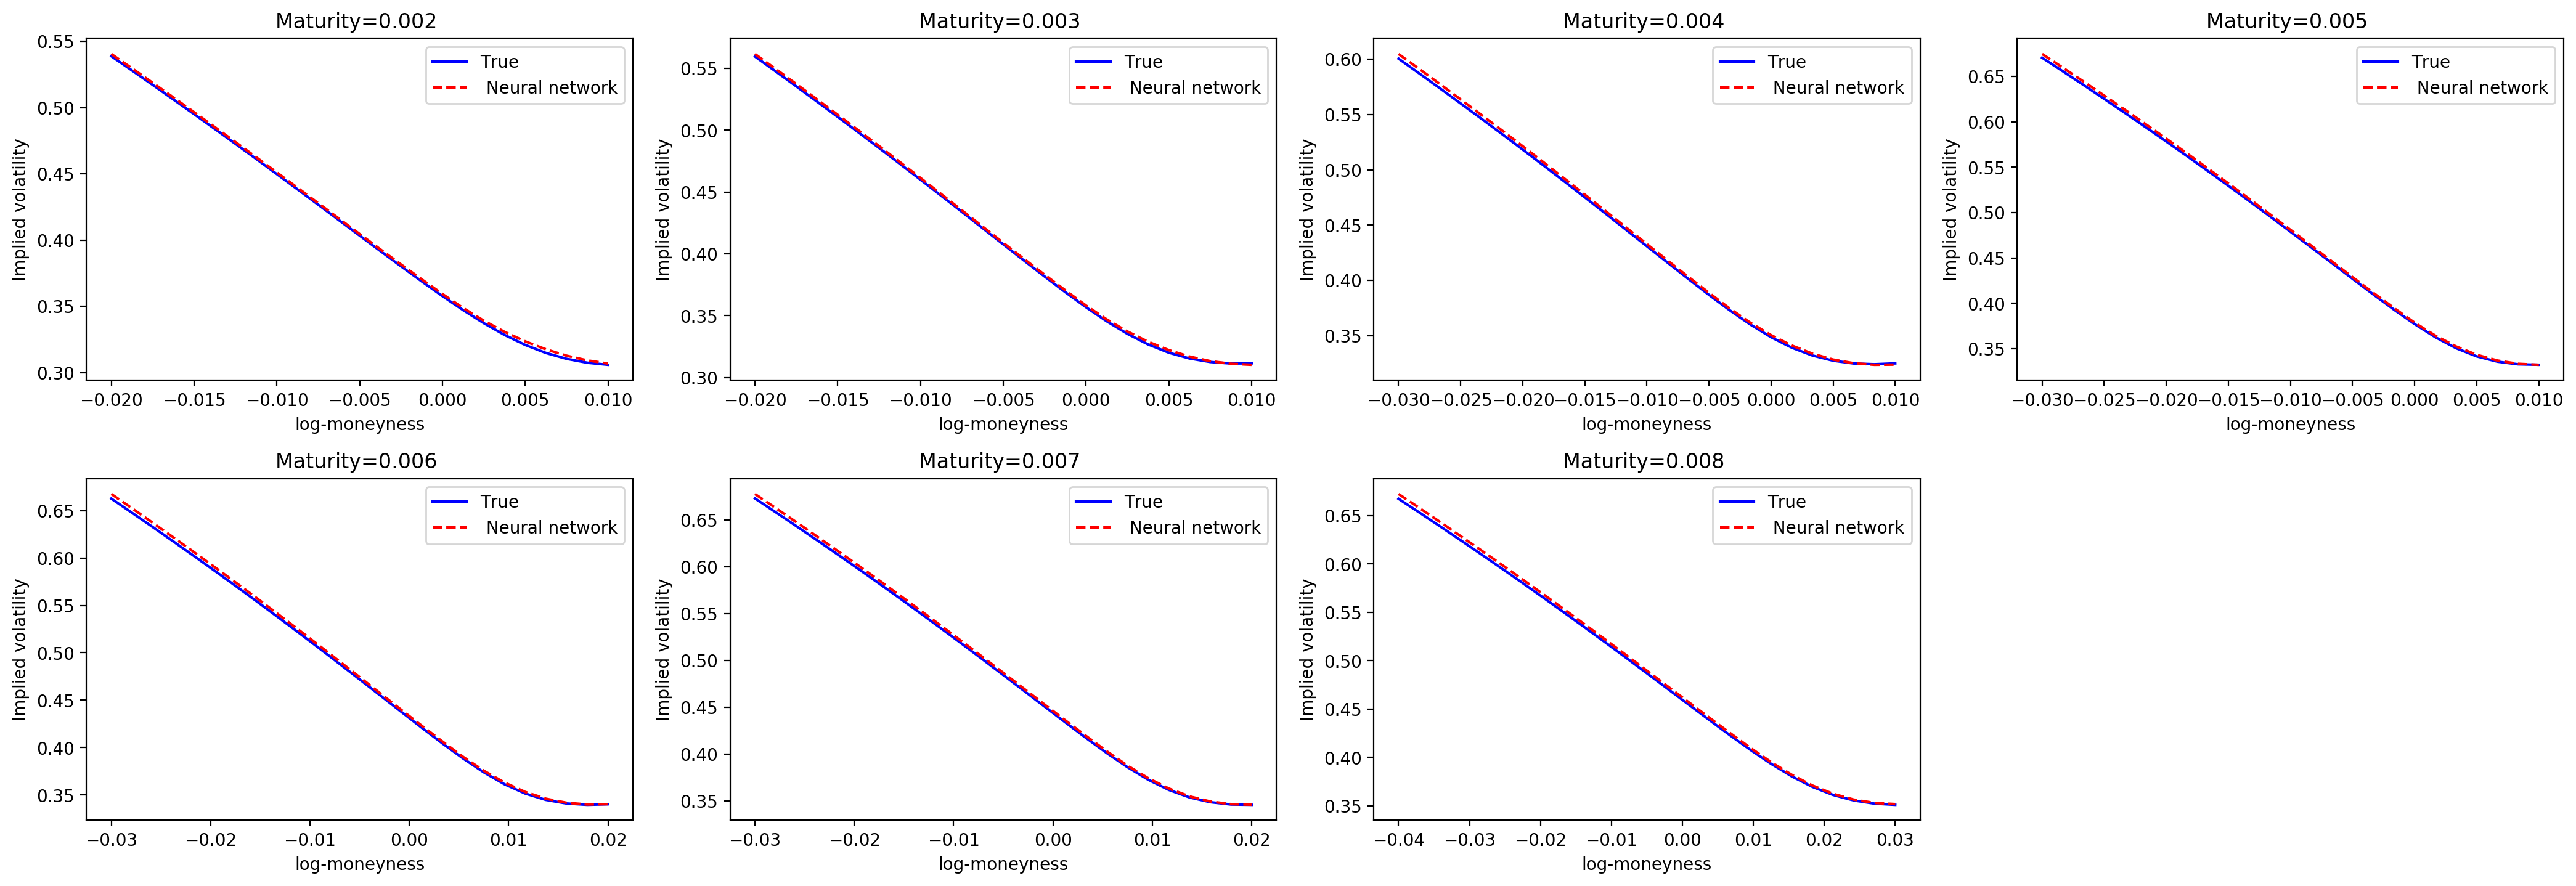

Model Parameters AdamW (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


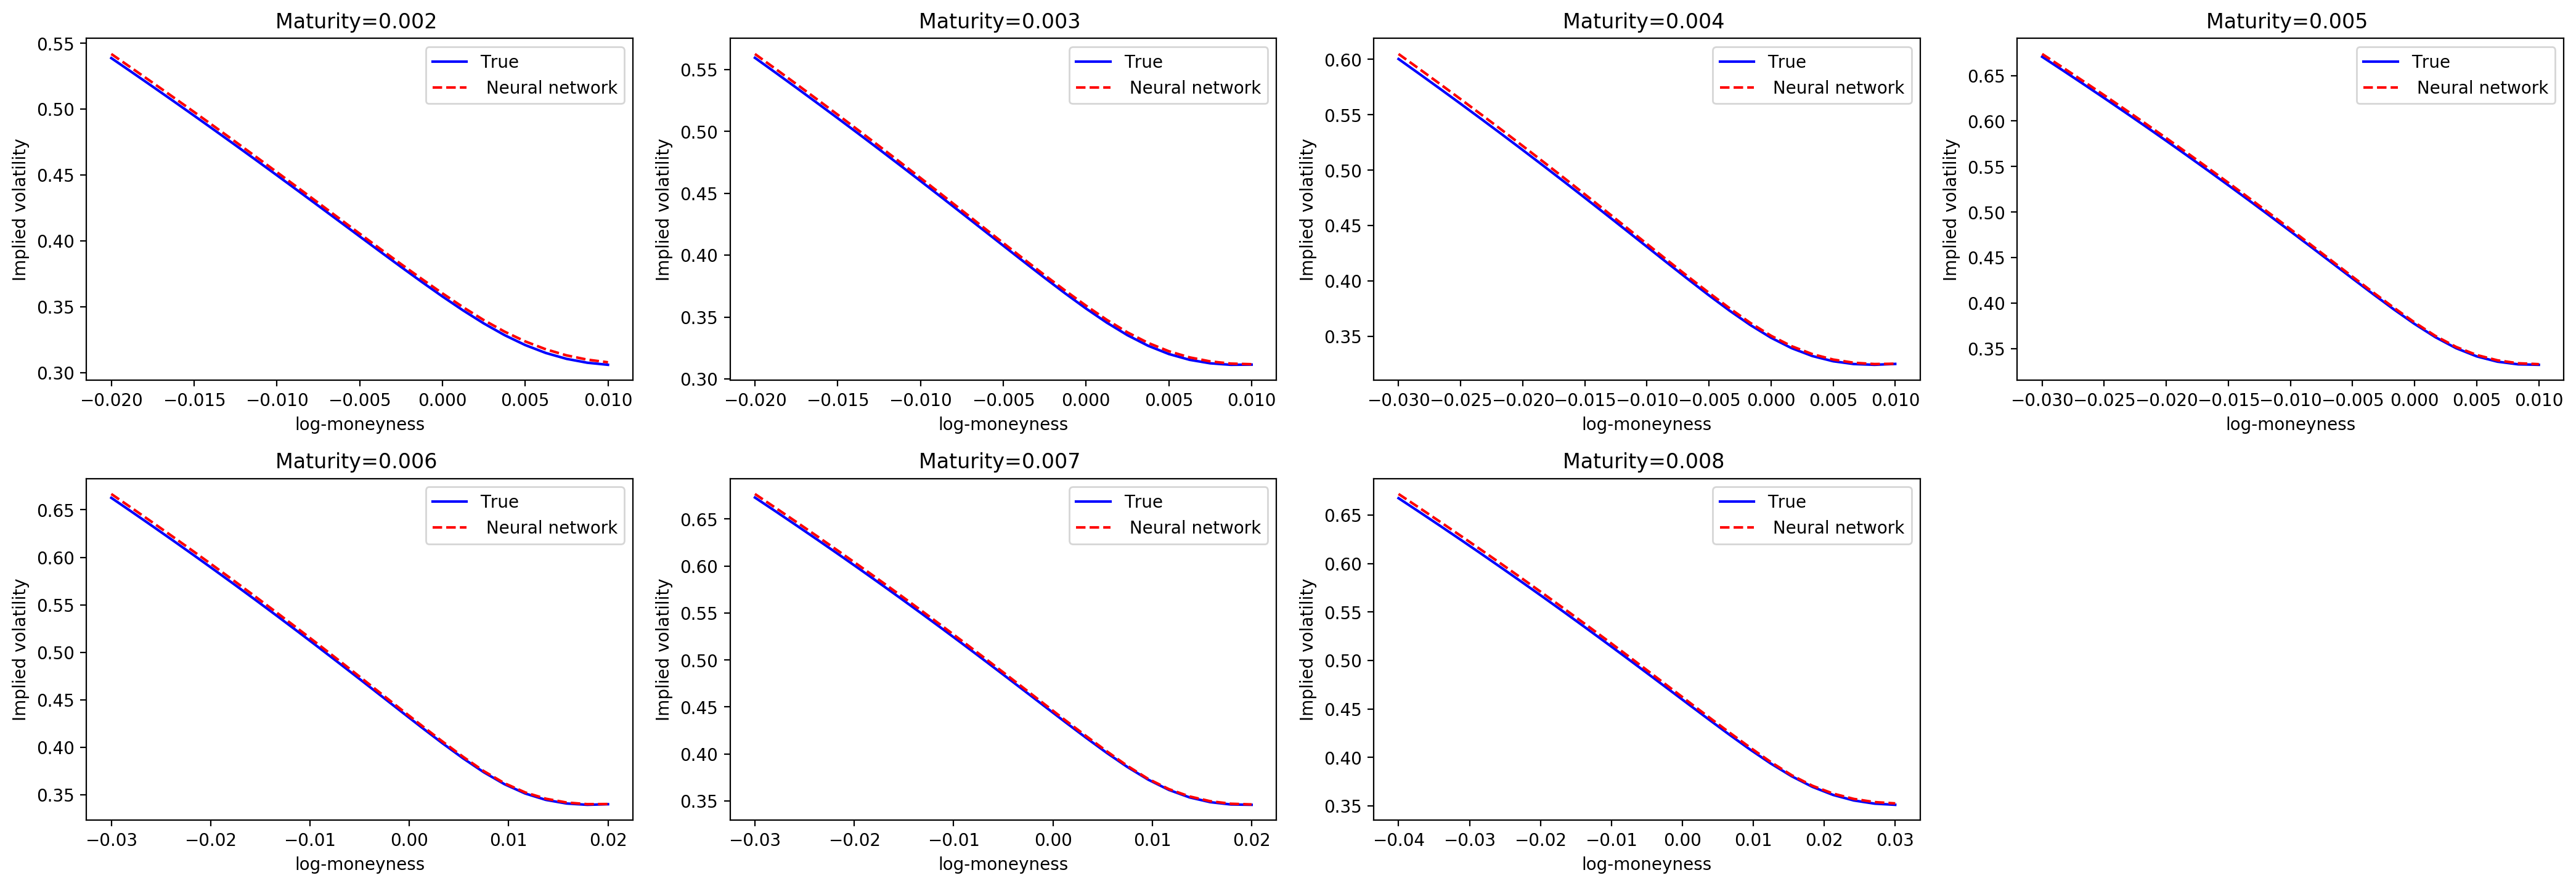

Model Parameters QHAdam (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


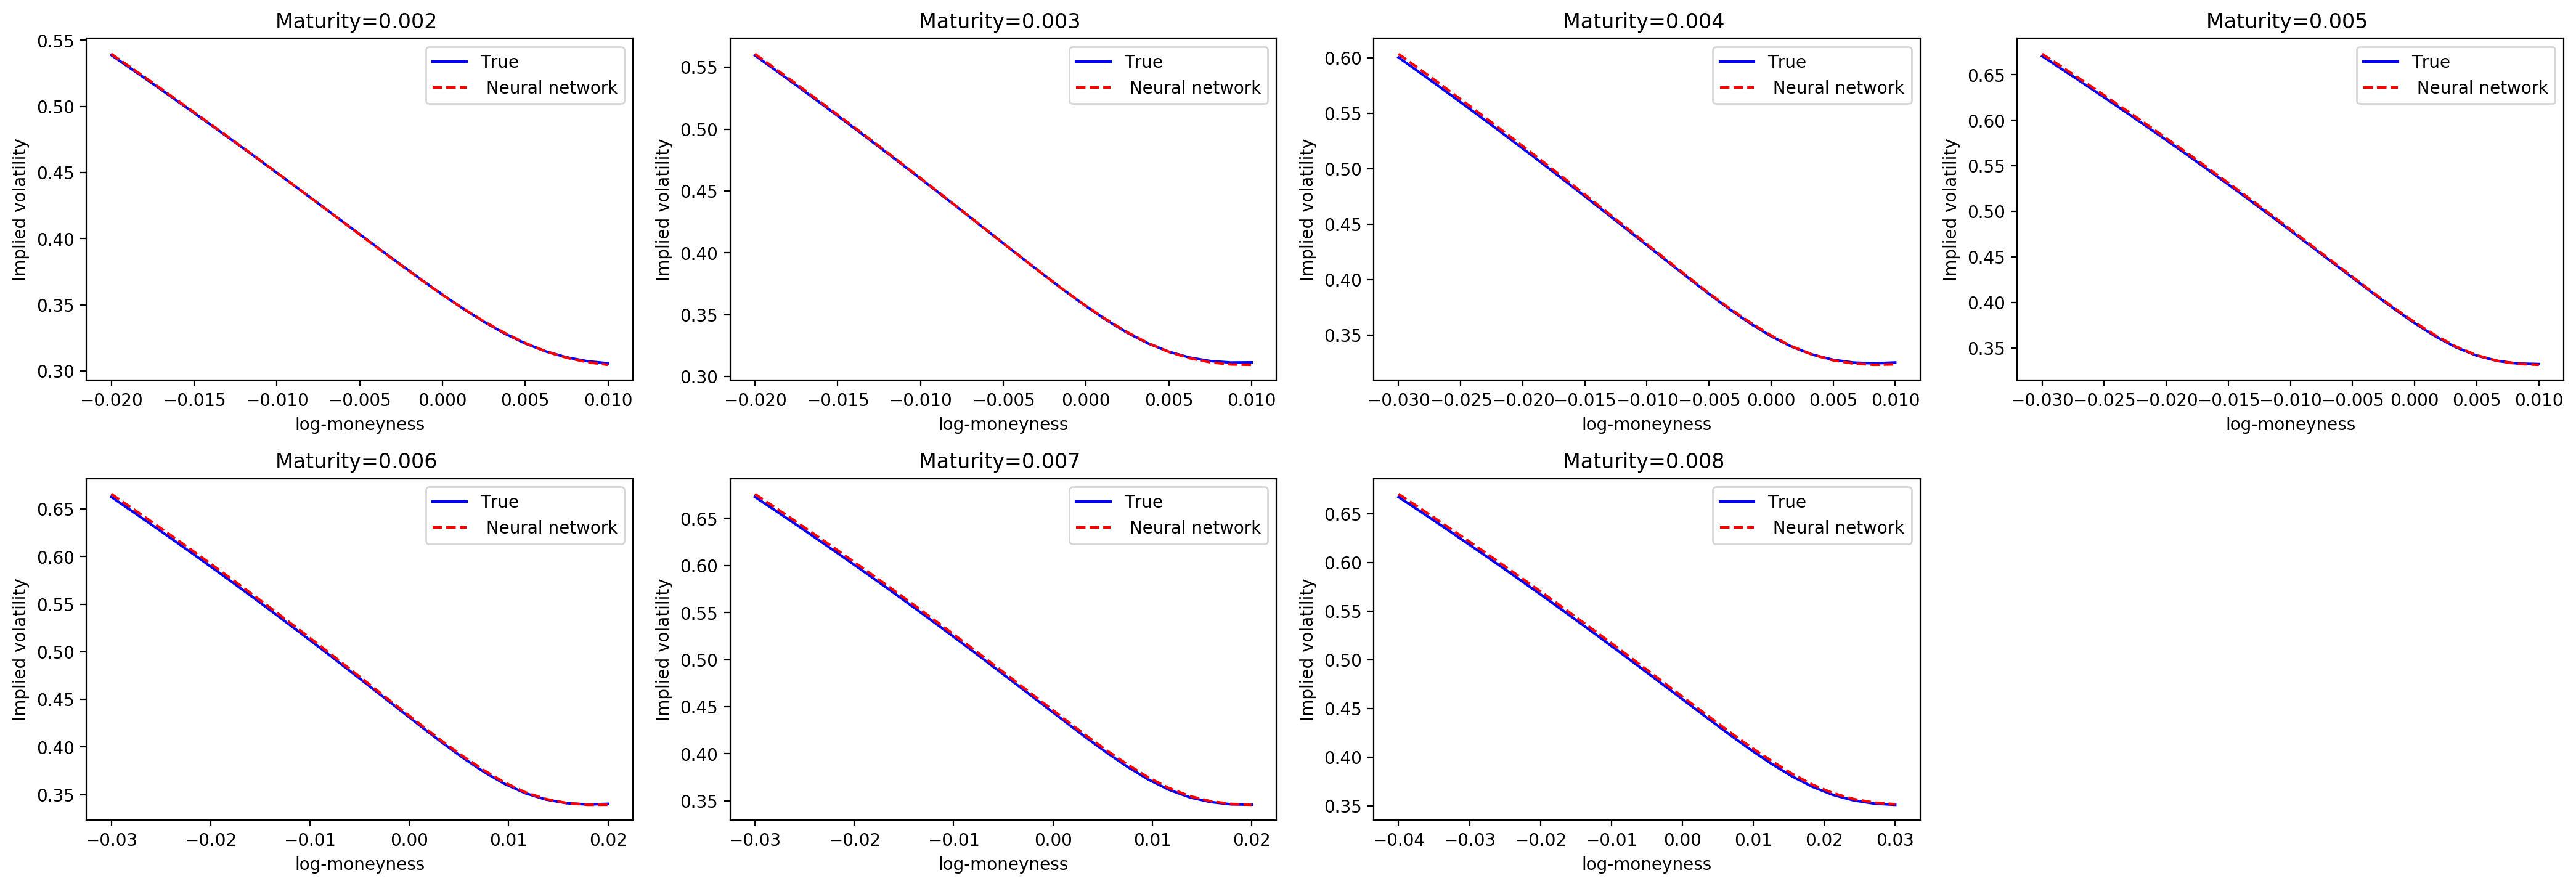

In [5]:
for key in optimizers:
    model = keras.models.load_model(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'rbergomi_model_' + MODEL_PART + '_' + key.__class__.__name__ + '.h5', 
                                    custom_objects={'root_mean_squared_error': root_mean_squared_error, 'QHAdam': QHAdam, 'AdamW' : AdamW})
    # Specify test sample to plot:
    sample_ind = 5006

    # Print parameters of test sample:
    print("Model Parameters " + key.__class__.__name__ + " (H,eta,rho,xi1,xi2,...): ",myinverse(x_valid_mod[sample_ind,:]))

    import scipy, matplotlib.pyplot as plt 
    npts = 25
    x_sample = x_valid_mod[sample_ind,:]
    y_sample = y_valid_mod[sample_ind,:]

    prediction = scale_y.inverse_transform(model.predict(x_valid_mod))
    plt.figure(1,figsize=(21,14), dpi = 200)
    j = -1
    for i in range(0,7):
        j = j + 1
        plt.subplot(4,4,j+1)
        plt.plot(logMoneyness[i*npts:(i+1)*npts],y_valid[sample_ind,i*npts:(i+1)*npts],'b',label="True")
        plt.plot(logMoneyness[i*npts:(i+1)*npts],prediction[sample_ind,i*npts:(i+1)*npts],'--r',label=" Neural network")

        plt.title("Maturity=%1.3f "%expiries[i*npts])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied volatility")

        plt.legend()
    plt.tight_layout()
    plt.show()

### Plot smothed training loss

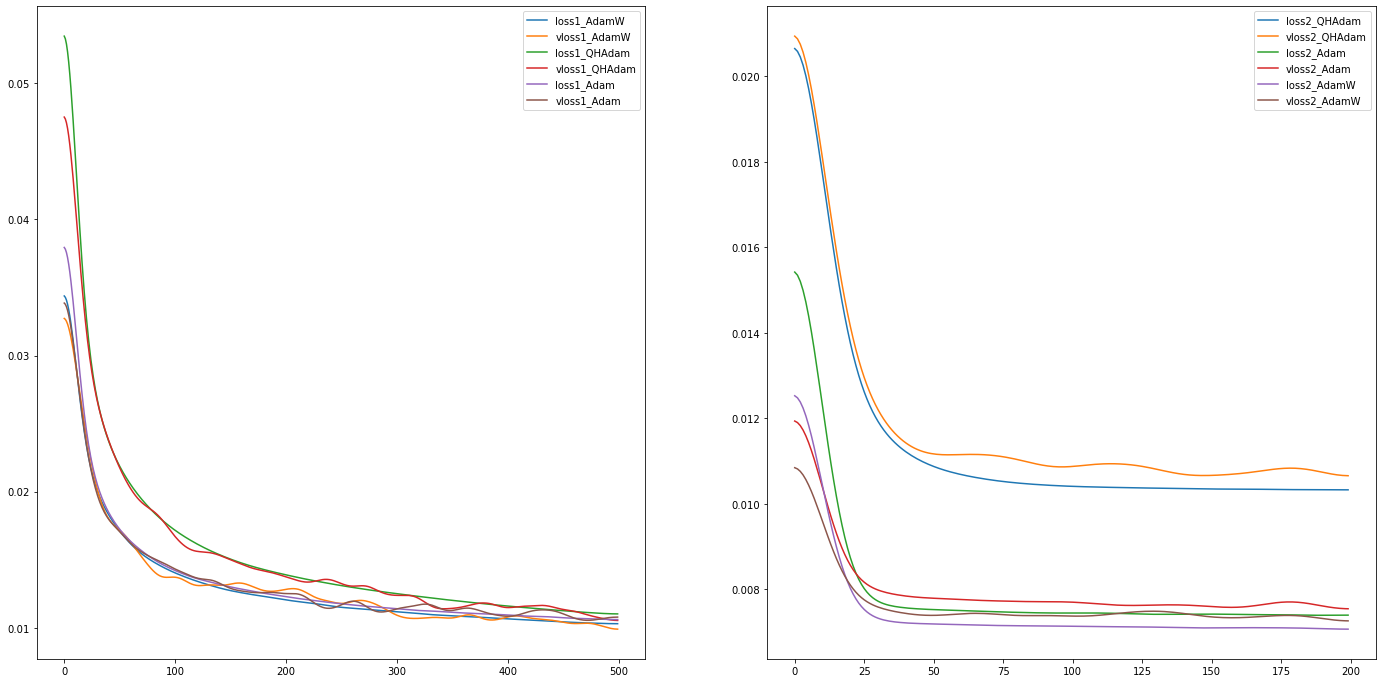

In [6]:
import pandas as pd
import glob
from scipy.ndimage.filters import gaussian_filter1d

fig, ax = plt.subplots(1, 2)

for i in range(1, len(optimizers)):
    path = wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'training_loss' + path_seperator
    all_files = glob.glob(path + path_seperator + "*" + MODEL_PART + "*loss" + str(i) + ".csv")
    li = []
    
    for filename in all_files:
        df = pd.read_csv(filename)
        df.iloc[:, 1:2] = gaussian_filter1d(df.iloc[:,1:2].T, sigma=10).T
        df.iloc[:, 0:1] = gaussian_filter1d(df.iloc[:,0:1].T, sigma=10).T
        li.append(df)

    frame = pd.concat(li, axis=1)
    frame.plot(figsize=(24,12), ax = ax[i-1])

### Save model predictions

In [7]:
import pandas as pd

for key in optimizers:
    model = keras.models.load_model(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'rbergomi_model_' + MODEL_PART + '_' + key.__class__.__name__ + '.h5', 
                                    custom_objects={'root_mean_squared_error': root_mean_squared_error, 'QHAdam': QHAdam, 'AdamW' : AdamW})

    prediction = scale_y.inverse_transform(model.predict(x_valid_mod))
    
    dl = {'prediction' + MODEL_PART: prediction.flatten(), 'y_valid' + MODEL_PART: y_valid.flatten()}
    df = pd.DataFrame(data=dl)

    df.to_csv(wd + path_seperator + 'data' + path_seperator + 'neural_network_weights' + path_seperator + 'rbergomi' + path_seperator + 'predictions' + path_seperator + 'pred' + MODEL_PART + '_' + key.__class__.__name__ + '.csv', encoding='utf-8', index=False)